## How to evaluate uncertainty quantification methods for speech emotion classifiers in real-world scnearios

In the following we will load the for non-comercial use available models we trained for the paper from zenodo and evaluate their uncertainty quantification capabilities on the proposed tests.

### Evaluate the model trained on cross entropy

In [1]:
import os

import audeer
import w2v2_cat as w2v2

pre_training_loss = 'kl_out' # use one of 'cross_entropy', 'edl', 'kl_in' or 'kl_out'
model_root = './pre-trained_models'
cache_root = 'cache'
audeer.mkdir(cache_root)
def cache_path(file):
    return os.path.join(cache_root, file)

zenodo_url = 'https://zenodo.org/records/13767256/files/' + pre_training_loss + '.zip'
dst_path = cache_path(pre_training_loss +'.zip')

if not os.path.exists(dst_path):
    audeer.download_url(
        zenodo_url, 
        dst_path, 
        verbose=True,
    )
    
if not os.path.exists(model_root+ '/' + pre_training_loss):
    audeer.extract_archive(
        dst_path, 
        model_root, 
        verbose=True,
    )

DEVICE = 'cpu'

model = w2v2.ModelCategorical
model = model.from_pretrained(model_root + '/' + pre_training_loss + '/torch')
model.to(DEVICE)
model.eval()


/home/oschruefer/projects/ser-uncertainty-quantification/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModelCategorical(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (proj

Define the prediction function

In [2]:
import numpy as np
import torch


def predict_func(
        signal: np.ndarray,
        sampling_rate: int,
) -> np.ndarray:
    y = torch.from_numpy(signal).to(DEVICE)

    with torch.no_grad():
        y = model(y)
        y['logits'] = torch.softmax(y['logits'], dim=-1)
     
    return y['logits'].squeeze().detach().cpu().numpy()

categorical_predictions = ["anger", "happiness", "neutral","sadness"]

Load Emodb

In [3]:
from omegaconf import OmegaConf
from data.create_data_frames import load_testing_data
import audeer

notebook_results = "./notebook_results/cat"

conf = OmegaConf.create({"test":{"important_columns_labels" : 
                        { "emotion" : ["anger", "happiness", "neutral","sadness"]},
                          "cache_path": "./notebook_csv/emodb",
                          "data_source_labeled_test": [{"name": "emodb",
                                                        "version": "1.4.1",
                                                        "table": "emotion.categories.test.gold_standard"}],
                          "uncertainty_method": "entropy",
                          "post_processing": "softmax",
                          "type": "correctness",
                                                        },
                        "results_root": notebook_results,
                        "sampling_rate": 16_000,
                        "testing": {"combined_df": "combined"},
                        })
audeer.mkdir(conf.results_root)
df_true = load_testing_data(conf.test)
df_true

Get:   emodb v1.4.1
Cache: /home/oschruefer/audb/emodb/1.4.1/fe182b91


,,,emotion
file,start,end,
/home/oschruefer/audb/emodb/1.4.1/fe182b91/wav/12a01Fb.wav,0 days,0 days 00:00:01.863625,happiness
/home/oschruefer/audb/emodb/1.4.1/fe182b91/wav/12a01Nb.wav,0 days,0 days 00:00:01.721937500,neutral
/home/oschruefer/audb/emodb/1.4.1/fe182b91/wav/12a01Wc.wav,0 days,0 days 00:00:02.358812500,anger
/home/oschruefer/audb/emodb/1.4.1/fe182b91/wav/12a02Nb.wav,0 days,0 days 00:00:01.731937500,neutral
/home/oschruefer/audb/emodb/1.4.1/fe182b91/wav/12a02Wa.wav,0 days,0 days 00:00:01.507437500,anger
...,...,...,...
/home/oschruefer/audb/emodb/1.4.1/fe182b91/wav/16b10Fb.wav,0 days,0 days 00:00:02.583500,happiness
/home/oschruefer/audb/emodb/1.4.1/fe182b91/wav/16b10Tb.wav,0 days,0 days 00:00:03.500625,sadness
/home/oschruefer/audb/emodb/1.4.1/fe182b91/wav/16b10Td.wav,0 days,0 days 00:00:03.934187500,sadness


emodb false vs correct

{'UAR': 0.8425925925925926, 'ACC': 0.875}


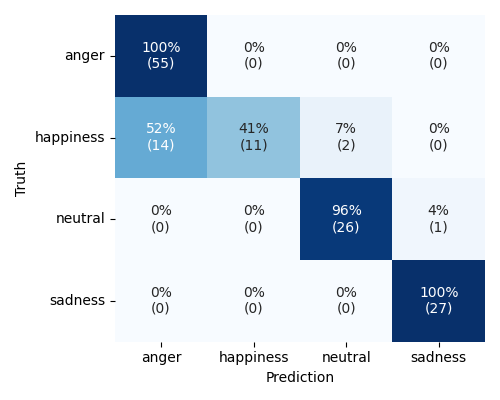

{'uncertainty.mean': 0.3329183531226376, 'uncertainty.std': 0.3052242295748311, 'precision.mean': -6.1357754e-09, 'precision.std': 5.5857328e-08, 'pcc-uncertain-precision': -0.06774150480427282, 'mode_max.mean': 0.0, 'mode_max.std': 0.0, 'pcc-uncertain-mode_max': nan, 'UAR': 0.8425925925925926, 'Acc': 0.875, 'mean uncertainty correct': 0.3006488403166991, 'mean uncertainty incorrect': 0.5588049427642079, 'uncertainty ratio': 1.858663223764878, 'UAR 0.0% - 20.0%': 0.875, 'Acc 0.0% - 20.0%': 0.7777777777777778, 'UAR 20.0% - 40.0%': 0.8177083333333333, 'Acc 20.0% - 40.0%': 0.8148148148148148, 'UAR 40.0% - 60.0%': 0.8214285714285714, 'Acc 40.0% - 60.0%': 0.8148148148148148, 'UAR 60.0% - 80.0%': 0.8333333333333334, 'Acc 60.0% - 80.0%': 0.9629629629629629, 'UAR 80.0% - 100.0%': 1.0, 'Acc 80.0% - 100.0%': 1.0}


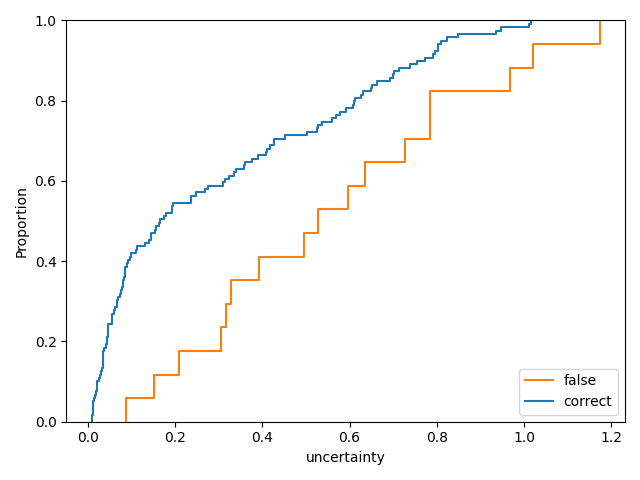

<Figure size 640x480 with 0 Axes>

In [4]:
from evaluation.tests import test_categorical, test_uncertainty
from IPython.display import Image, display
results = test_categorical(df_true, categorical_predictions, predict_func, pre_training_loss, conf.test, conf)
print(results)
display(Image(notebook_results + '/' + pre_training_loss + '.cm.png'))
results = test_uncertainty(df_true, categorical_predictions, predict_func, pre_training_loss, conf.test, conf)
print(results)
display(Image(notebook_results + '/' + pre_training_loss + '.png'))

### emodb vs cochlscene vs whitenoise

repeat uncertainty tests for cochlscene and artificial whitenoise

In [8]:
from evaluation.tests import test_ood_data

conf.test_white = {"important_columns_labels" : {"gain" : None},
                  "cache_path": "./notebook_csv/white",
                  "data_source_artificaial_test": "white_noise",
                  "uncertainty_method": "entropy",
                  "post_processing": "softmax",
                  "type": "ood",
                  }

df_true = load_testing_data(conf.test_white) 
results = test_ood_data(df_true, categorical_predictions, predict_func, pre_training_loss+'_white', conf.test_white, conf)

conf.test_musan = {"important_columns_labels" : {"background_noise": None},
                  "cache_path": "./notebook_csv/musan",
                  "data_source_labeled_test": [{"name": "musan",
                              "version": "1.0.0",
                              "table": "noise"}],
                  "uncertainty_method": "entropy",
                  "post_processing": "softmax",
                  "type": "ood",
                  }

df_true = load_testing_data(conf.test_musan) 
results = test_ood_data(df_true, categorical_predictions, predict_func, pre_training_loss+'_musan', conf.test_musan, conf)

                                                                           uncertainty  \
file                                               start  end                            
/home/oschruefer/artifical_dbs/white_noise-50db... 0 days 0 days 00:00:08     0.497124   
/home/oschruefer/artifical_dbs/white_noise-48db... 0 days 0 days 00:00:08     0.502360   
/home/oschruefer/artifical_dbs/white_noise-46db... 0 days 0 days 00:00:08     0.505761   
/home/oschruefer/artifical_dbs/white_noise-44db... 0 days 0 days 00:00:08     0.508286   
/home/oschruefer/artifical_dbs/white_noise-42db... 0 days 0 days 00:00:08     0.509618   
/home/oschruefer/artifical_dbs/white_noise-40db... 0 days 0 days 00:00:08     0.510540   
/home/oschruefer/artifical_dbs/white_noise-38db... 0 days 0 days 00:00:08     0.511151   
/home/oschruefer/artifical_dbs/white_noise-36db... 0 days 0 days 00:00:08     0.511515   
/home/oschruefer/artifical_dbs/white_noise-34db... 0 days 0 days 00:00:08     0.511768   
/home/osch

                                                                                     uncertainty  \
file                                               start  end                                      
/home/oschruefer/audb/musan/1.0.0/fe182b91/nois... 0 days 0 days 00:00:17.658750        0.796455   
/home/oschruefer/audb/musan/1.0.0/fe182b91/nois... 0 days 0 days 00:00:40.536500        0.893122   
/home/oschruefer/audb/musan/1.0.0/fe182b91/nois... 0 days 0 days 00:01:11.217500        0.821595   
/home/oschruefer/audb/musan/1.0.0/fe182b91/nois... 0 days 0 days 00:00:14.235812500     0.881879   
/home/oschruefer/audb/musan/1.0.0/fe182b91/nois... 0 days 0 days 00:00:02.986500        0.603620   
...                                                                                          ...   
/home/oschruefer/audb/musan/1.0.0/fe182b91/nois... 0 days 0 days 00:00:03.604000        0.770330   
/home/oschruefer/audb/musan/1.0.0/fe182b91/nois... 0 days 0 days 00:00:58.618750        0.950500   


In [9]:
from evaluation.evaluation_main import evaluate_combined_results

evaluate_combined_results(conf)

emodb + whitenoise

Everything for CE + KL(out)